# 오차역전파법 (Backpropagation)

이전에는 수치 미분방법을 통해 가중치 매개변수의 기울기를 구함.
단순하고 구현하기 쉽움, But 계산시간이 오래걸림.

가중치 매개변수를 효율적으로 계산하기위해 **오차역전파**를 사용함.

## 계산 그래프 (Computational graph)

계산 과정을 그래프로 나타낸 것

여기서 말하는 그래프는 컴퓨터 사이언스에서 말하는 그래프 자료구조이며, 다수의 노드 (Node)와 엣지 (Edge)로 구성되어 있다.

## 계산 그래프를 이용한 문제 풀이

전산학 시간에 일반적으로 다루는 수식 트리와 유사한 접근이다.
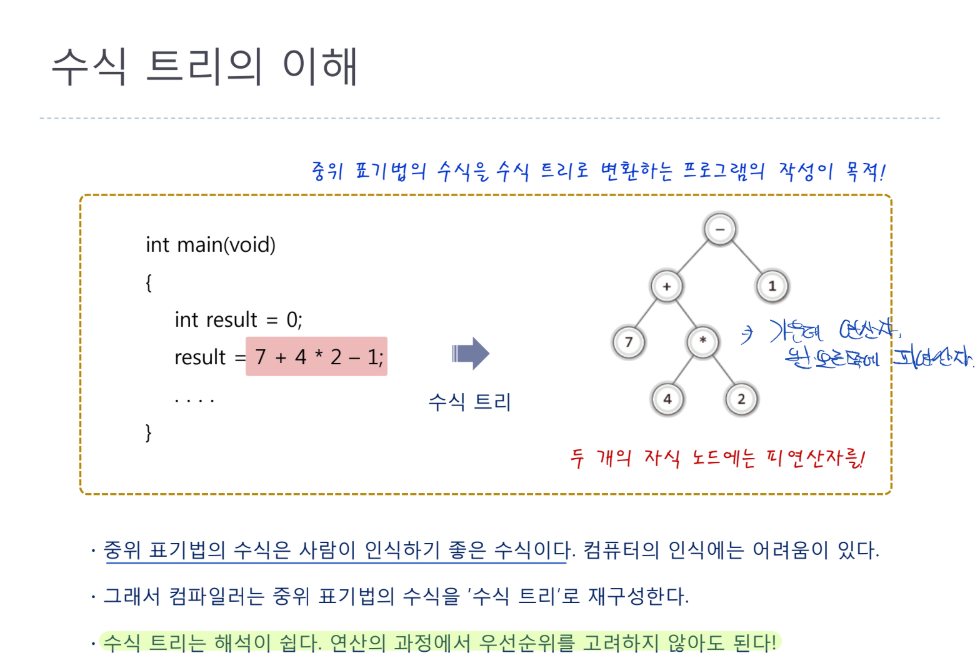

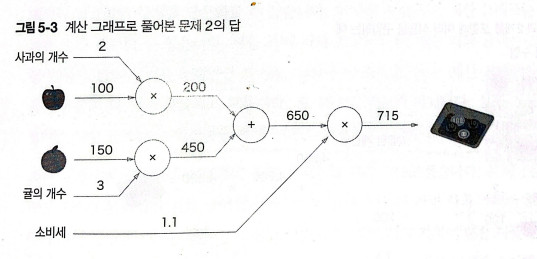

수식 트리와 마찬가지로 입력 노드와 그것을 연산하는 곱셈 노드 또는 덧셈 노드 등으로 구성되어 있다.

간단하게 구성되어 있어 계산 과정을 직관적으로 파악할 수 있다는 것이 특징이다.

이렇게 왼쪽에서 오른쪽으로 진행하는 단계를 순전파 (Forward propagation)이라고 한다.
반대방향으로 진행하는 것이 이번에 다룰 역전파 (Back propagation)이다.

## 국소적 계산

계산 그래프의 특징은 **국소적 계산**을 전파함으로써 최종결과를 얻는다는 점임

여기서 **국소적**이라는 뜻은 자신과 직접 관계된, 또는 직접 연결된 노드만 고려한다는 의미

탐욕적 알고리즘과 유사한 특성.

## 왜 계산 그래프로 푸는가?

계산 그래프의 장점

1. 국소적 계산을 통해 계산 과정 단순화
2. 중간 계산 결과를 모두 보관 가능
3. 역전파를 통해 미분을 효율적으로 계산 가능

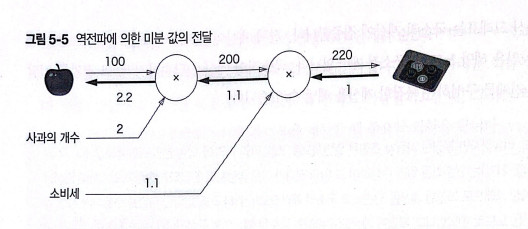

## 연쇄 법칙 (Chain rule)

합성 함수: 여러 함수로 구성된 함수

$$ z = t^2 $$
$$ t = x + y $$

연쇄 법칙은 이러한 합성 함수의 미분에 대한 성질

합성 함수의 미분은 합성 함수를 구성하는 각 함수의 미분의 곱으로 나타낼 수 있다.

$$ \frac{\partial z}{\partial x} = \frac{\partial z}{\partial t}\frac{\partial t}{\partial x} $$

계산 그래프 표현

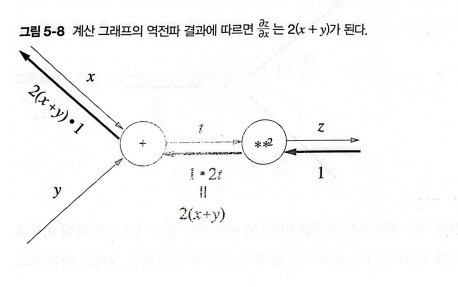




## 역전파

### 덧셈 노드의 역전파

덧셈 노드의 역전파는 입력 값을 그대로 흘려보낸다.

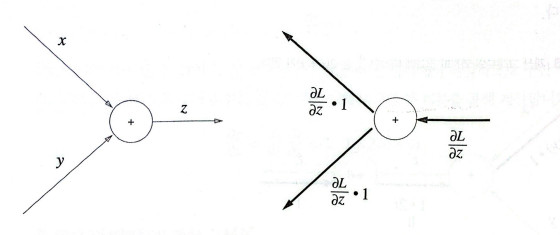

### 곱셈 노드의 역전파

순전파 때의 입력 신호들을 서로 바꾼 값을 곱해서 하류로 흘러보낸다.

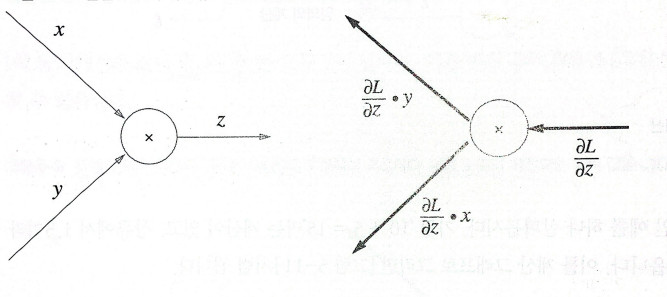

## 단순한 계층 구현

지금까지 파악한 곱셈 노드와 덧셈 노드를 코드로 구현한다.

In [19]:
class MulLayer:
  def __init__(self):
    self.x = None
    self.y = None
  
  def forward(self, x, y):
    # backward에서 활용하기 위해 x, y 저장
    self.x = x
    self.y = y
    
    return x * y

  def backward(self, dout):
    dx = dout * self.y
    dy = dout * self.x

    return dx, dy

In [20]:
class AddLayer:
  def __init__(self):
    pass
  
  def forward(self, x, y):
    return x + y

  def backward(self, dout):
    dx = dout * 1
    dy = dout * 1
    
    return dx, dy

### 문제 해결 예시

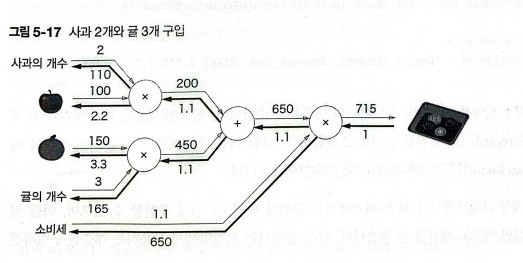

In [21]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(price)
print([dapple_num, dapple, dorange, dorange_num, dtax])

715.0000000000001
[110.00000000000001, 2.2, 3.3000000000000003, 165.0, 650]


## 활성화 함수 계층 구현

### ReLU

수식
$$
\begin{cases}
    x (x > 0)\\
    0 (x <= 0)\\
\end{cases}
$$

미분
$$
\frac{\partial y}{\partial x}=\begin{cases}
    1 (x > 0)\\
    0 (x <= 0)\\
\end{cases}
$$

x보다 크면 입력신호 통과, 작거나 같으면 0

In [22]:
class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0

    return out
  
  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout

    return dx

In [23]:
# 마스크 설명
import numpy as np


x = np.array([[1.0, -0.5], [-2.0, 3.0]])
print(x)
mask = (x <= 0)
print(mask)

[[ 1.  -0.5]
 [-2.   3. ]]
[[False  True]
 [ True False]]


### Sigmoid

수식

$$
\frac {1}{1+e^{-x}}
$$

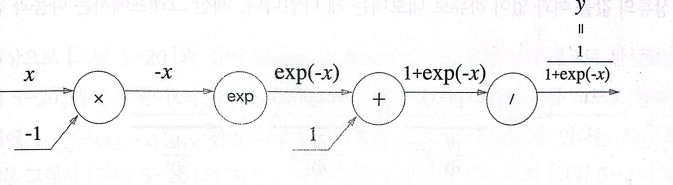

#### 1단계: '/'노드 미분

$y = \frac{1}{x}$을 미분

$$
\frac{\partial y}{\partial x} = - \frac{1}{x^2} = -y^2
$$

#### 2단계: '+' 노드 미분

'+' 노드는 입력 값을 그대로 통과 시킨다.

#### 3단계: 'exp' 노드 미분

$$
\frac {\partial y}{\partial x} = e^x
$$

#### 4단계: 'x' 노드 미분

'x' 노드는 순전파에서의 값을 서로 바꿔서 곱해준다.

#### 최종 식

$$
\frac{\partial L}{\partial y}y(1-y)
$$


In [24]:
# 구현

class Sigmoid:
  def __init__(self):
    self.out = None

  def forward(self, x):
    out = 1 / 1 + np.exp(-x)
    self.out = out

    return out

  def backward(self, dout):
    dx = dout * (1.0 - self.out) * self.out

    return dx

## Affine 계층 구현

신경망의 순전파에서 행렬의 내적을 사용했다.

행렬의 내적은 기하학에서 Affine transformation이라고 부른다.

따라서 이러한 Affine transformation을 수행하는 계층을 Affine 계층이라고 정의한다.

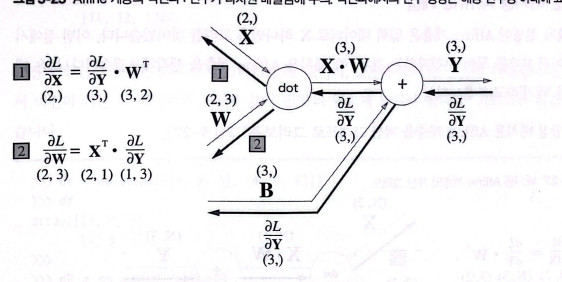

배치형의 경우 입출력 차원이 변형된 것임


In [25]:
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.dW = None
    self.db = None

  def forward(self, x):
    self.x = x
    out = np.dot(x, self.W) + self.b

    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)

    return dx

## Softmax-with-Loss 계층

소프트맥스는 입력 값을 정규화하여 출력한다.
출력 값이 1이 되도록

*정규화하지 않은 출력의 경우 score라고 함
확률로서 사용하기 위해서는 softmax가 필요함

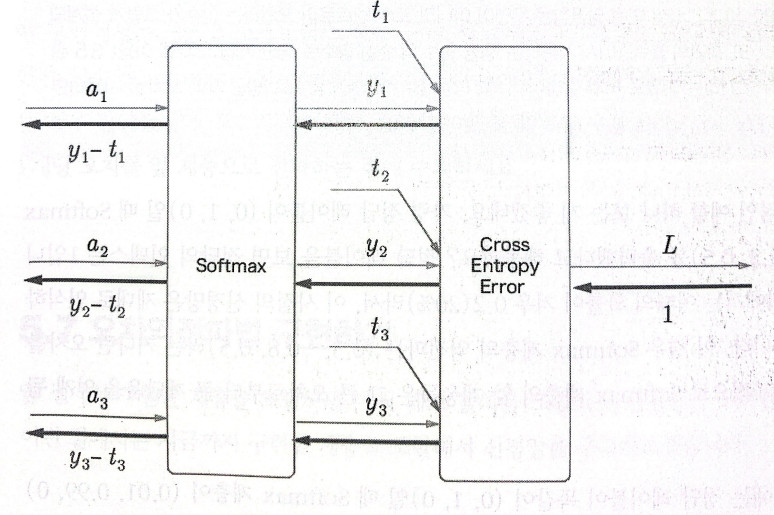



### 순전파

수식

softmax

$$
y_k = \frac{e^{a_k}}{\sum_{i=1}^{n}e^{a_i}}
$$

계산 그래프

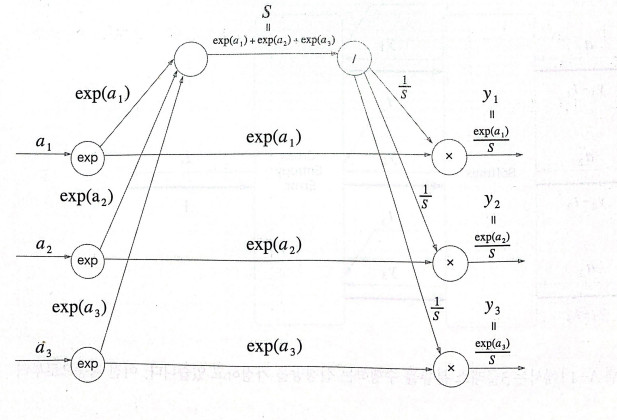

cross-entropy

$$
L = -\sum_{k} t_k log y_k
$$

계산 그래프

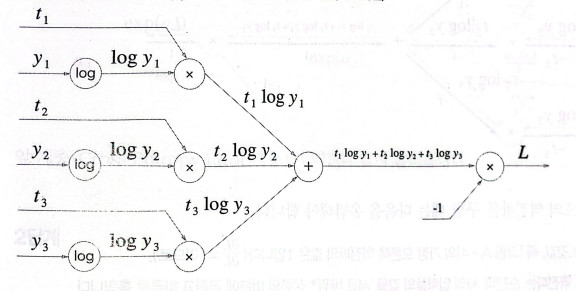

### 역전파

#### Cross Entropy Error

역전파 계산 그래프

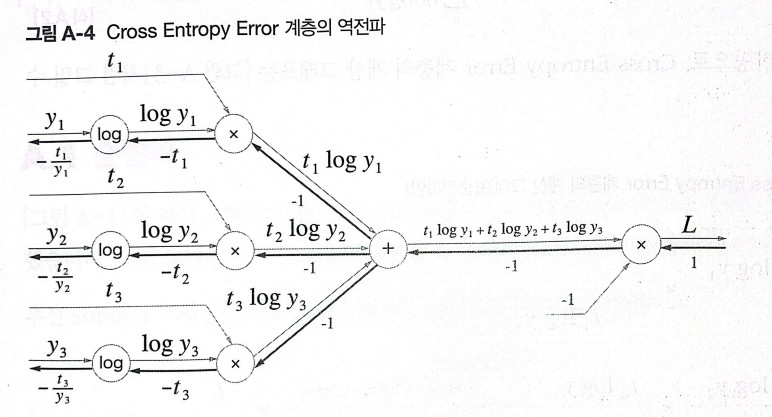

1. 초기 값은 1
2. 'x' 노드 역전파: 값을 서로 바꿔 곱함
3. '+' 노드: 그대로 전파
3. 'log' 노드 역전파

log 역전파는 다음과 같음

$$
y = log x
$$

$$
\frac {\partial y}{\partial x} = \frac {1}{x}
$$

최종적으로 다음과 같아짐

$$
-\frac{t_i}{y_i}
$$

#### Softmax

역전파 계산 그래프

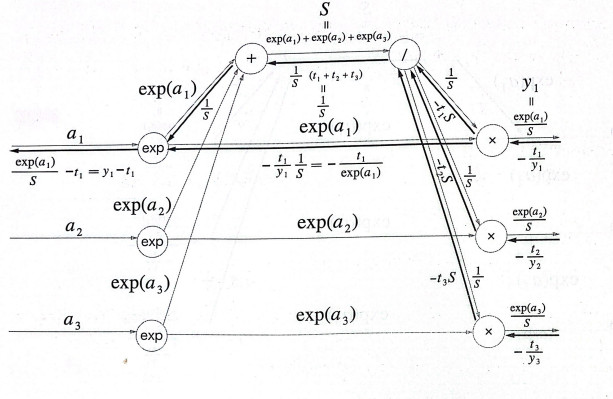

1. 초기 값은 앞의 Cross-Entropy Error의 역전파 결과
2. 'x' 노드에서 서로 바궈 곱함 
$$
-\frac{t_1}{y_1}e^{a_1} = -t_1 \frac{S}{e^{a_1}}e^{a_1} = - t_1S
$$
3. 순전파에서 나뉘어진 값들이 다시 합쳐짐
$$ \frac{1}{S}(t_1 + t_2 + t_3) $$
여기서 $(t_1 + t_2 + t_3)$는 원-핫 벡터임 따라서 총합은 1
따라서 $\frac{1}{S}$로 요약 가능
4. '+' 노드: 그냥 통과
5. 2에서 처리한 'x' 노드의 다른 입력 방향으로 역전파
6. 'exp' 노드 계산
지수 함수의 미분을 활용한다.
$$
y = e^x
$$

$$
\frac{\partial y}{\partial x} = e^x
$$

$$
\frac{e^{a_1}}{S}-t_1 = y_1 - t_1
$$
위 식으로 요약된다.
기억하자 $\frac{e^{a_1}}{S}$은 입력값으로 들어온 값이라서 $y_1$으로 정리된거임



In [26]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    return self.loss

  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    dx = (self.y - self.t) / batch_size

    return dx


## 오차역전파법 구현

지금까지의 계층들을 조합하여 신경망을 구현할 수 있음

신경망 학습 순서

1. 미니배치
2. 기울기 산출
3. 매개변수 갱신
4. 반복

In [27]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad

In [31]:
from typing import OrderedDict
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
          x = layer.forward(x)
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)

        if t.ndim != 1:
          t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
          dout = layer.backward(dout)

        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads

In [29]:
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import os
import numpy as np


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = os.path.dirname('.')
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
def download_mnist():
    for v in key_file.values():
       _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])    
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNIST 데이터셋 읽기
    
    Parameters
    ----------
    normalize : 이미지의 픽셀 값을 0.0~1.0 사이의 값으로 정규화할지 정한다.
    one_hot_label : 
        one_hot_label이 True면、레이블을 원-핫(one-hot) 배열로 돌려준다.
        one-hot 배열은 예를 들어 [0,0,1,0,0,0,0,0,0,0]처럼 한 원소만 1인 배열이다.
    flatten : 입력 이미지를 1차원 배열로 만들지를 정한다. 
    
    Returns
    -------
    (훈련 이미지, 훈련 레이블), (시험 이미지, 시험 레이블)
    """
    if not os.path.exists(save_file):
        init_mnist()
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])    
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 

In [32]:
# 기울기 검증

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)


for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:3.37013185774632e-10
b1:2.2488784160988617e-09
W2:5.059675242976923e-09
b2:1.3987059594294803e-07


In [35]:
# 학습 구현
import datetime as dt

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

start_time = dt.datetime.now()
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.numerical_gradient(x_batch, t_batch) # 수치 미분 방식
    # grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식(훨씬 빠르다)
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

print(f'end time {dt.datetime.now() - start_time}')

0.07613333333333333 0.0777


KeyboardInterrupt: ignored

In [34]:
# 학습 구현
import datetime as dt

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

start_time = dt.datetime.now()
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch) # 수치 미분 방식
    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식(훨씬 빠르다)
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

print(f'end time {dt.datetime.now() - start_time}')

0.10591666666666667 0.1058
0.9006666666666666 0.9061
0.92215 0.9238
0.9333666666666667 0.9307
0.9461666666666667 0.9428
0.9515666666666667 0.9483
0.9567333333333333 0.9536
0.9622333333333334 0.9591
0.96515 0.9608
0.9686 0.9645
0.9700666666666666 0.9655
0.9723 0.9661
0.9741166666666666 0.9674
0.9751833333333333 0.9676
0.9767333333333333 0.969
0.97755 0.9698
0.9800666666666666 0.972
end time 0:00:44.521388


### 결과

수치 미분:

역전파:
0:00:44.521388

